In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os
import zipfile

sys.path.append('../Code')
import PSTHM 
import time
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

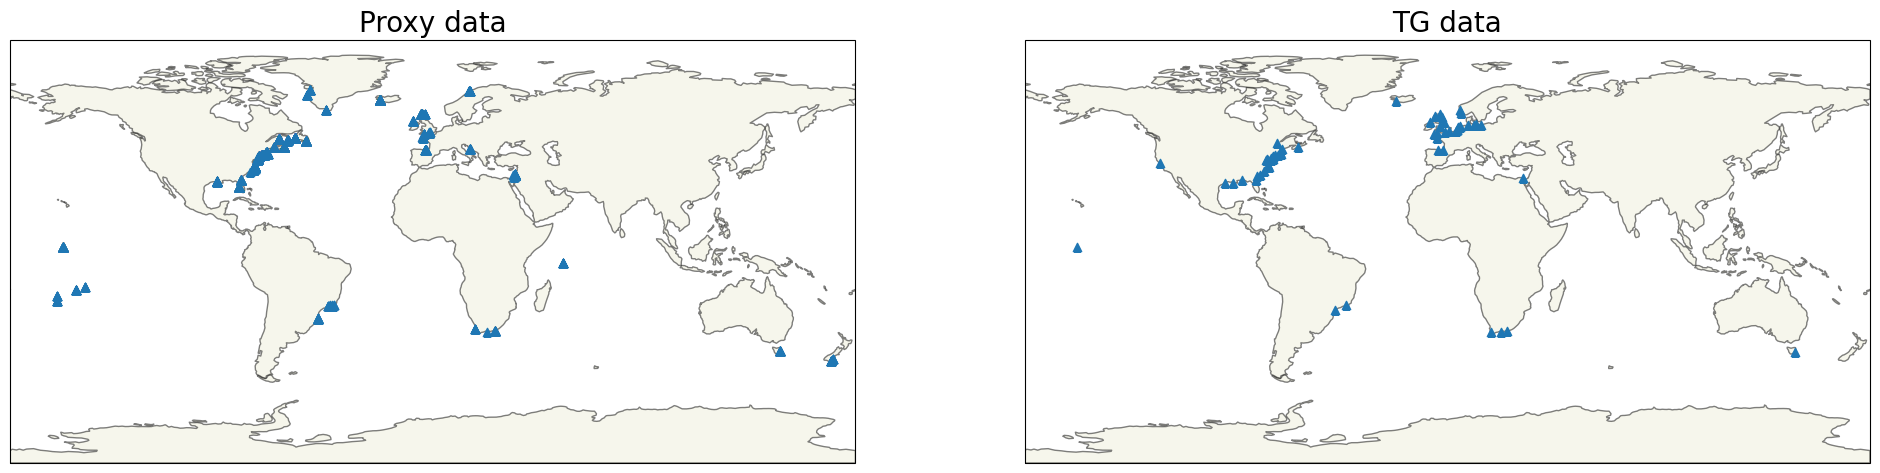

In [3]:

#load the proxy data
proxy_data = pd.read_csv('IFILES/RSL_All_17Mar2020.tsv', sep='\t', header=0, encoding= 'unicode_escape')
trainfirsttime = -1000
proxy_data = proxy_data[proxy_data['Age (CE)']>trainfirsttime]

TG_ID = pd.read_excel('IFILES/TG_ID.xlsx',skiprows=np.arange(1,4))

TG_data_folder = '../Data/TG_data/'

if len(os.listdir(TG_data_folder))<5:
    with zipfile.ZipFile(TG_data_folder+'TG_data.zip', 'r') as zip_ref:
        zip_ref.extractall(TG_data_folder)
site_file = pd.read_table(TG_data_folder+'/filelist.txt',delimiter=';',header=None)
selection_index = np.array([i in list(TG_ID['PSMSL ID']) for i in site_file.iloc[:,0]])
selected_sites = site_file.iloc[selection_index,:]

plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.scatter(proxy_data['Longitude (¡E)'],proxy_data['Latitude (¡N)'],transform=ccrs.PlateCarree(),zorder=1,
            marker='^')
ax2.set_title('Proxy data',fontsize=20)

ax1 = plt.subplot(122,projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax1.scatter(selected_sites.iloc[:,2],selected_sites.iloc[:,1],transform=ccrs.PlateCarree(),zorder=1,
            marker='^')
ax1.set_title('TG data',fontsize=20);

**Load results from Hay et al., 2015**

In [4]:
import scipy.io as sio
gslfile = os.path.join('IFILES', 'Hay2015_KFandGP_GMSL.mat')

Haydat = sio.loadmat(gslfile)
Hay = {}

Hay['Y'] = Haydat['KF_GMSL'][0]
Hay['dY'] = np.sqrt(np.diag(Haydat['KF_GMSL_var']))
Hay['Ycv'] = Haydat['KF_GMSL_var']
Hay['datid'] = np.zeros_like(Hay['Y'])
Hay['time1'] = Haydat['tt_KF'][:]
Hay['time2'] = Hay['time1']
Hay['meantime'] = Hay['time1']
Hay['lat'] = np.ones_like(Hay['Y']) * 1e6
Hay['long'] = Hay['lat']
Hay['compactcorr'] = np.zeros_like(Hay['Y'])
Hay['limiting'] = np.zeros_like(Hay['Y'])
Hay['istg'] = np.ones_like(Hay['Y'])
Hay['siteid'] = 0
Hay['sitenames'] = ['Hay_KF_GMSL']
Hay['sitecoords'] = [1e6, 1e6]
Hay['sitelen'] = len(Hay['Y'])

# Smooth Hay et al curve
Hayavgwin = 10
Haystep = 10
HayGSL = Hay.copy()
HayGSL['time1'] = np.arange(1885, 2006, Haystep)
HayGSL['time2'] = HayGSL['time1']
HayGSL['meantime'] = HayGSL['time1']
M = np.abs(np.subtract.outer(HayGSL['time1'], Hay['time1'])) <= (Hayavgwin / 2)
M = M[:,0,:]
M = M / np.sum(M, axis=1, keepdims=True)
HayGSL['Y'] = M @ Hay['Y']
HayGSL['Ycv'] = M @ Hay['Ycv'] @ M.T
HayGSL['dY'] = np.sqrt(np.diag(HayGSL['Ycv']))
HayGSL['datid'] = np.zeros_like(HayGSL['Y'])
HayGSL['lat'] = np.ones_like(HayGSL['Y']) * 1e6
HayGSL['long'] = HayGSL['lat']
HayGSL['compactcorr'] = np.zeros_like(HayGSL['Y'])
HayGSL['limiting'] = np.zeros_like(HayGSL['Y'])
HayGSL['istg'] = np.ones_like(HayGSL['Y'])


**Load three old TG data**

In [5]:
import os
from scipy.sparse import dia_matrix

# old tide gauges

TGold = {
    'datid': [],
    'meantime': [],
    'Y': [],
    'dY': [],
    'lat': [],
    'long': [],
    'siteid': [],
    'sitenames': [],
    'sitecoords': [],
    'sitelen': [],
    'time1': [],
    'time2': [],
    'limiting': [],
    'compactcorr': [],
    'istg': [],
    'Ycv': None
}

for ppp in range(1, 4):
    if ppp == 1:
        dat = pd.read_csv(os.path.join('IFILES', 'amsterdam.sea.level.txt'), delim_whitespace=True,header=None)
        wsite = 'AMSTERDAM_OLD'
        wcurid = 5001
        wlat = [52.3667]
        wlong = [4.9000]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 1].values
    elif ppp == 2:
        dat = pd.read_csv(os.path.join('IFILES', 'Kronstadt_ReportsFGI_Bogdanov_appendix.csv'))
        wsite = 'KRONSTADT_OLD'
        wcurid = 5002
        wlat = [59.98]
        wlong = [29.77]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values
    elif ppp == 3:
        dat = pd.read_csv(os.path.join('IFILES', 'ekman_2003_stockholm.csv'),skiprows=1)
        wsite = 'STOCKHOLM_OLD'
        wcurid = 5003
        wlat = [59.32]
        wlong = [18.08]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values

    TGold['datid'].extend(wdatid)
    TGold['meantime'].extend(wtime)
    TGold['Y'].extend(wY)
    TGold['dY'] = np.ones(len(TGold['Y'])) * 3
    TGold['lat'].extend(np.ones_like(wY) * wlat)
    TGold['long'].extend(np.ones_like(wY) * wlong)
    TGold['siteid'].extend(np.ones_like(wY) * wcurid)
    TGold['sitenames'].append(wsite)
    TGold['sitecoords'].append([wlat[0], wlong[0]])
    TGold['sitelen'].append(len(wY))

TGold['time1'] = TGold['meantime']
TGold['time2'] = TGold['meantime']
TGold['limiting'] = np.zeros_like(TGold['datid'])
TGold['compactcorr'] = np.zeros_like(TGold['datid'])
TGold['istg'] = np.ones_like(TGold['datid'])
TGold['Ycv'] = dia_matrix((TGold['dY']**2, 0), shape=(len(TGold['Y']), len(TGold['Y'])))


**Load Gaussian Process Smoothed TG data**

Note that here we use the same TG data as we did in the other Notebook for Kopp et al., 2016, so the TG data could be slightly different compared to Walker et al., 2022.

In [6]:
new_TG_rsl_data = pd.read_csv('IFILES/Decadal_TG.csv')
old_TG_rsl_data = pd.read_csv('IFILES/Decadal_old_TG.csv')

In [7]:
GSLflattener = {}
GSLflattener['sigma'] = 1e4
GSLflattener['time1'] = 0.01 + np.concatenate((np.arange(-100, 101, 50), np.arange(1600, 1801, 50)))
GSLflattener['Y'] = np.zeros_like(GSLflattener['time1'])
GSLflattener['Ycv'] = np.ones((len(GSLflattener['Y']), len(GSLflattener['Y']))) * (GSLflattener['sigma']**2)

GSLflattener['Ycv'][:5, :5] += ((0.0025 * 1700)**2 + np.eye(5) * GSLflattener['sigma']**2 - GSLflattener['sigma']**2 / 5)
GSLflattener['Ycv'][5:10, 5:10] += (np.eye(5) * GSLflattener['sigma']**2 - GSLflattener['sigma']**2 / 5)

GSLflattener['dY'] = np.sqrt(np.diag(GSLflattener['Ycv']))
GSLflattener['datid'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['time2'] = GSLflattener['time1']
GSLflattener['meantime'] = GSLflattener['time1']
GSLflattener['lat'] = np.ones_like(GSLflattener['Y']) * 1e6
GSLflattener['long'] = GSLflattener['lat']
GSLflattener['compactcorr'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['limiting'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['istg'] = np.ones_like(GSLflattener['Y'])
GSLflattener['siteid'] = 0
GSLflattener['sitenames'] = ['GSLflattener']
GSLflattener['sitecoords'] = [1e6, 1e6]
GSLflattener['sitelen'] = len(GSLflattener['Y'])


**Pseudo data so that average rate of change between -100 to 100 CE and 1600-1800 CE is close to zero**

In [8]:
#combined proxy and TG data 

X = np.hstack((proxy_data['Age (CE)'],new_TG_rsl_data['Year (CE)'],old_TG_rsl_data['Year (CE)'],GSLflattener['meantime'],HayGSL['meantime']))
y = np.hstack((proxy_data['RSL (m)'],new_TG_rsl_data['RSL (mm)']/1000,old_TG_rsl_data['RSL (mm)']/1000,
                GSLflattener['Y']/1000,HayGSL['Y']/1000))
proxy_x_sigma = (proxy_data['Age +2s'] + proxy_data['Age -2s'])/4
X_sigma = np.hstack((proxy_x_sigma,np.zeros(len(new_TG_rsl_data)),np.zeros(len(old_TG_rsl_data)),
                    np.zeros(len(GSLflattener['meantime'])),np.zeros(len(HayGSL['meantime']))))

proxy_y_sigma = (proxy_data['RSL +1s'] + proxy_data['RSL -1s'])/2
y_sigma = np.hstack((proxy_y_sigma,new_TG_rsl_data['RSL std (mm)']/1000,
                    old_TG_rsl_data['RSL std (mm)']/1000,GSLflattener['dY']/1000,HayGSL['dY']/1000))

longitude = np.hstack([proxy_data['Longitude (¡E)'],new_TG_rsl_data['Longitude'],old_TG_rsl_data['Longitude'],
                    GSLflattener['long']/200,HayGSL['long']/2000])
longitude[longitude<0]+=360
latitude = np.hstack([proxy_data['Latitude (¡N)'],new_TG_rsl_data['Latitude'],old_TG_rsl_data['Latitude'],
                    GSLflattener['lat']/200,HayGSL['lat']/2000])

X_all = np.vstack([X,latitude,longitude]).T

#filter out data with too old age or too large uncertainty
filter_1 = (X<-1000) &(X>2010)
filter_2 = X_sigma>=100
filter_all = filter_1 | filter_2
X = X[~filter_all]
y = y[~filter_all]
X_sigma = X_sigma[~filter_all]
y_sigma = y_sigma[~filter_all]
X_all = X_all[~filter_all]
longitude = longitude[~filter_all]
latitude = latitude[~filter_all]


**Load ICE5G Model**

In [9]:
#load ICE5G
import netCDF4 as nc
nc = nc.Dataset('IFILES/dsea250.1grid.ICE5Gv1.3_VM2_L90_2012.nc')
lon = nc.variables['Lon'][:]
lat = nc.variables['Lat'][:]
Lon_mat,Lat_mat = np.meshgrid(lon,lat)
GIA = nc.variables['Dsea_250'][:]

#interpolate ICE5G linear rate to all sites
from scipy import interpolate
long_index = longitude<360

GIA_rate = interpolate.griddata(np.vstack([Lon_mat.flatten(),Lat_mat.flatten()]).T, GIA.flatten(), (longitude[long_index], latitude[long_index]), method='linear')

y_no_GIA = y.copy()
y_no_GIA[long_index] = y_no_GIA[long_index] - GIA_rate*(X[long_index]-2010)/1000

In [10]:
from tqdm.notebook import tqdm

def SVI_NI_optm(gpr,x_sigma,num_iteration=1000,lr=0.05,decay_r = 1,step_size=100,gpu=False):
    '''
    A funciton to optimize the hyperparameters of a GP model using SVI

    ---------Inputs-----------
    gpr: a GP model defined by pyro GPR regression
    x_sigma: one sigma uncertainty for input data
    num_iteration: number of iterations for the optimization
    lr: learning rate for the optimization
    step_size: step size for the learning rate to decay. 
    A step size of 100 with a decay rate of 0.9 means that the learning rate will be decrease 10% for every 100 steps.
    gpu: whether use gpu to accelerate training 
    ---------Outputs-----------
    gpr: a GP model with optimized hyperparameters
    track: a dictionary of loss
    '''
    
    #clear the param store
    pyro.clear_param_store()
    #convert the model to double precision
    gpr = gpr.double()
    #define the optimiser
    optimizer = torch.optim.Adam(gpr.parameters(), lr=lr)
    #define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay_r)
    #define the loss function
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    #do the optimisation
    track_list = []
    N = len(gpr.X)
    if gpr.noise.dim()==1:
        y_sigma = gpr.noise**0.5
    elif gpr.noise.dim()==2:
        y_sigma = gpr.noise.view(-1)[:: N + 1]**0.5


    for i in tqdm(range(num_iteration)):
        #update vertical noise based on gradient
        if gpu:
            x_test = torch.tensor(gpr.X.clone(),requires_grad=True).cuda()
        else:
            x_test = torch.tensor(gpr.X.clone(),requires_grad=True)
        y_mean, _ = gpr(x_test.double(), full_cov=False)
        y_mean.sum().backward(retain_graph=True)
        if gpu:
            y_rate = x_test.grad.cuda()
        else:
            y_rate = x_test.grad
        if y_rate.ndim>1: y_rate = y_rate[:,0]
        new_sigma = torch.sqrt((y_rate**2*(x_sigma)**2)+y_sigma**2)
        if gpr.noise.dim()==1:
            gpr.noise = torch.tensor(new_sigma**2)
        elif gpr.noise.dim()==2:
            gpr.noise.view(-1)[:: N + 1] = torch.tensor(new_sigma**2)
            
        scheduler.step()
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        gpr.set_mode("guide")
        tem_para =  []
        
        #use fast global kernel's lengthscale for fast regional and local non-linear kernel
        gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.lengthscale
        #local non linear fast         
        gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.lengthscale

        #use fast global kernel's lengthscale for slow regional and local non-linear kernel
        #regional non linear slow
        gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.lengthscale
        #local non linear slow
        gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.lengthscale
        
        #set same spatial length scale for reigonal and local kernel 
        gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale
        gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale

        #set local variance equal to regional variance
        gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance
        gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.variance = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance

        

        for i2 in pyro.get_param_store().values():
            if i2.numel()==1:
                tem_para.append(i2.item())
            else:
                for i3 in i2:
                    tem_para.append(i3.item())
        
        track_list.append([loss.item(),*tem_para])
    
    #generate columns names for the track list
    col_name = ['loss' ]

    for i in (dict(pyro.get_param_store()).keys()):
        if pyro.get_param_store()[i].numel() ==1:
            col_name.append(i[7:].replace('_map',''))
        else:
            for i2 in range(pyro.get_param_store()[i].numel()):
                col_name.append(i[7:].replace('_map','')+'_'+str(i2))
    #convert the track list to a dataframe
    track_list=pd.DataFrame(track_list,columns=col_name)

    return gpr,track_list

In [11]:
# filter out data with poor quality

pyro.clear_param_store()
#define global temporal kernel fast
global_kernel_f = PSTHM.Matern32(input_dim=1,geo=False)
global_kernel_f.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(30.)))
global_kernel_f.set_prior("variance", dist.Uniform(torch.tensor(1e-8), torch.tensor(1e-4)))

#define global temporal kernel slow
global_kernel_s = PSTHM.Matern32(input_dim=1,geo=False)
global_kernel_s.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(400.)))
global_kernel_s.set_prior("variance", dist.Uniform(torch.tensor(1e-4), torch.tensor(5e-1)))

#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = gp.kernels.Polynomial(input_dim=1)
regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-8), torch.tensor(1e-4)))
regional_linear_temporal_kernel.set_prior("bias", dist.Uniform(torch.tensor(2010.**2-0.5), torch.tensor(2010.**2+0.5)))
regional_linear_spatial_kernel = PSTHM.Matern21(input_dim=1,geo=True)
regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.20)))
regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

#define fast regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_f = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,geo=False)
regional_nl_temporal_kernel_f.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(1e-2)))
regional_nl_spatial_kernel_f = PSTHM.Matern21(input_dim=1,geo=True)
regional_nl_spatial_kernel_f.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.35)))
regional_nl_kernel_f = gp.kernels.Product(regional_nl_temporal_kernel_f, regional_nl_spatial_kernel_f)

#define slow regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_s = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,geo=False)
regional_nl_temporal_kernel_s.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(5e-2)))
regional_nl_spatial_kernel_s = PSTHM.Matern21(input_dim=1,s_lengthscale =regional_nl_spatial_kernel_f.s_lengthscale,geo=True)
regional_nl_kernel_s = gp.kernels.Product(regional_nl_temporal_kernel_s, regional_nl_spatial_kernel_s)

#define fast locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_f = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,
                                            variance =regional_nl_temporal_kernel_f.variance ,geo=False)
local_nl_spatial_kernel_f = PSTHM.Matern21(input_dim=1,geo=True)
local_nl_spatial_kernel_f.set_prior("s_lengthscale", dist.Uniform(torch.tensor(1e-4), torch.tensor(1e-3)))
local_nl_kernel_f = gp.kernels.Product(local_nl_temporal_kernel_f, local_nl_spatial_kernel_f)

#define slow locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_s = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,
                                            variance =regional_nl_temporal_kernel_s.variance ,geo=False)
local_nl_spatial_kernel_s = PSTHM.Matern21(input_dim=1,lengthscale = local_nl_spatial_kernel_f.s_lengthscale,geo=True)
local_nl_kernel_s = gp.kernels.Product(local_nl_temporal_kernel_s, local_nl_spatial_kernel_s)

#define white-noise kernel
sp_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=True,geo=False)
sp_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

s_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=False,geo=True)
s_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

#define constant offset kernel
constant_kernel = gp.kernels.Constant(input_dim=1)
constant_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-10),torch.tensor(1e-3)))

combined_sp_kernel = gp.kernels.Sum(global_kernel_f,global_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel_f)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel_f)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,s_whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,constant_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_linear_kernel)

N = len(X_all)
noise_cov = torch.zeros(N,N).double()
noise_cov.view(-1)[:: N + 1] += 1e-5 + torch.tensor(y_sigma**2)
noise_cov[np.outer(longitude>500,longitude>500)] = torch.tensor(GSLflattener['Ycv']/1000**2).flatten()
noise_cov[np.outer((longitude>360) &(longitude<501) ,(longitude>360) &(longitude<501))] =  torch.tensor(HayGSL['Ycv']/1000**2).flatten()

gpr = PSTHM.GPRegression_V(torch.tensor(X_all), torch.tensor(y_no_GIA), combined_sp_kernel,noise=noise_cov,jitter=1e-5)


In [12]:
#Walker et al., 2021
gpr.kernel.kern1.kern0.variance = 1.21e-6
gpr.kernel.kern1.kern0.bias = 2010**2
gpr.kernel.kern1.kern1.s_lengthscale = 0.06283185307179587

gpr.kernel.kern0.kern1.variance = torch.tensor(4e-8)
gpr.kernel.kern0.kern0.kern1.variance =2.5e-09
gpr.kernel.kern0.kern0.kern0.kern1.variance = 2.5e-09

gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = 356
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.variance = 0.0009
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.0006981317007977319

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = 11
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = 0.0004
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.0006981317007977319

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = 356
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = 0.0009
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.1884955592153876

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = 11
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = 0.0004
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.1884955592153876

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.variance = 0.0169
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.lengthscale =356

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.variance = 1e-06
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.lengthscale = 11


In [12]:
test_age = np.arange(-1000,2020,10)
#generate prediction for one location
data_point = X_all[300,1:]
pred_matrix = PSTHM.gen_pred_matrix(test_age,*data_point)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()
#-----------------define the kernel to decompose-----------------
test_global_kernel =   gp.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1)
test_global_kernel =   gp.kernels.Sum(test_global_kernel,gpr.kernel.kern0.kern1)

regional_linear_kernel = gpr.kernel.kern1
regional_nl_kernel =  gpr.kernel.kern0.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[test_global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()


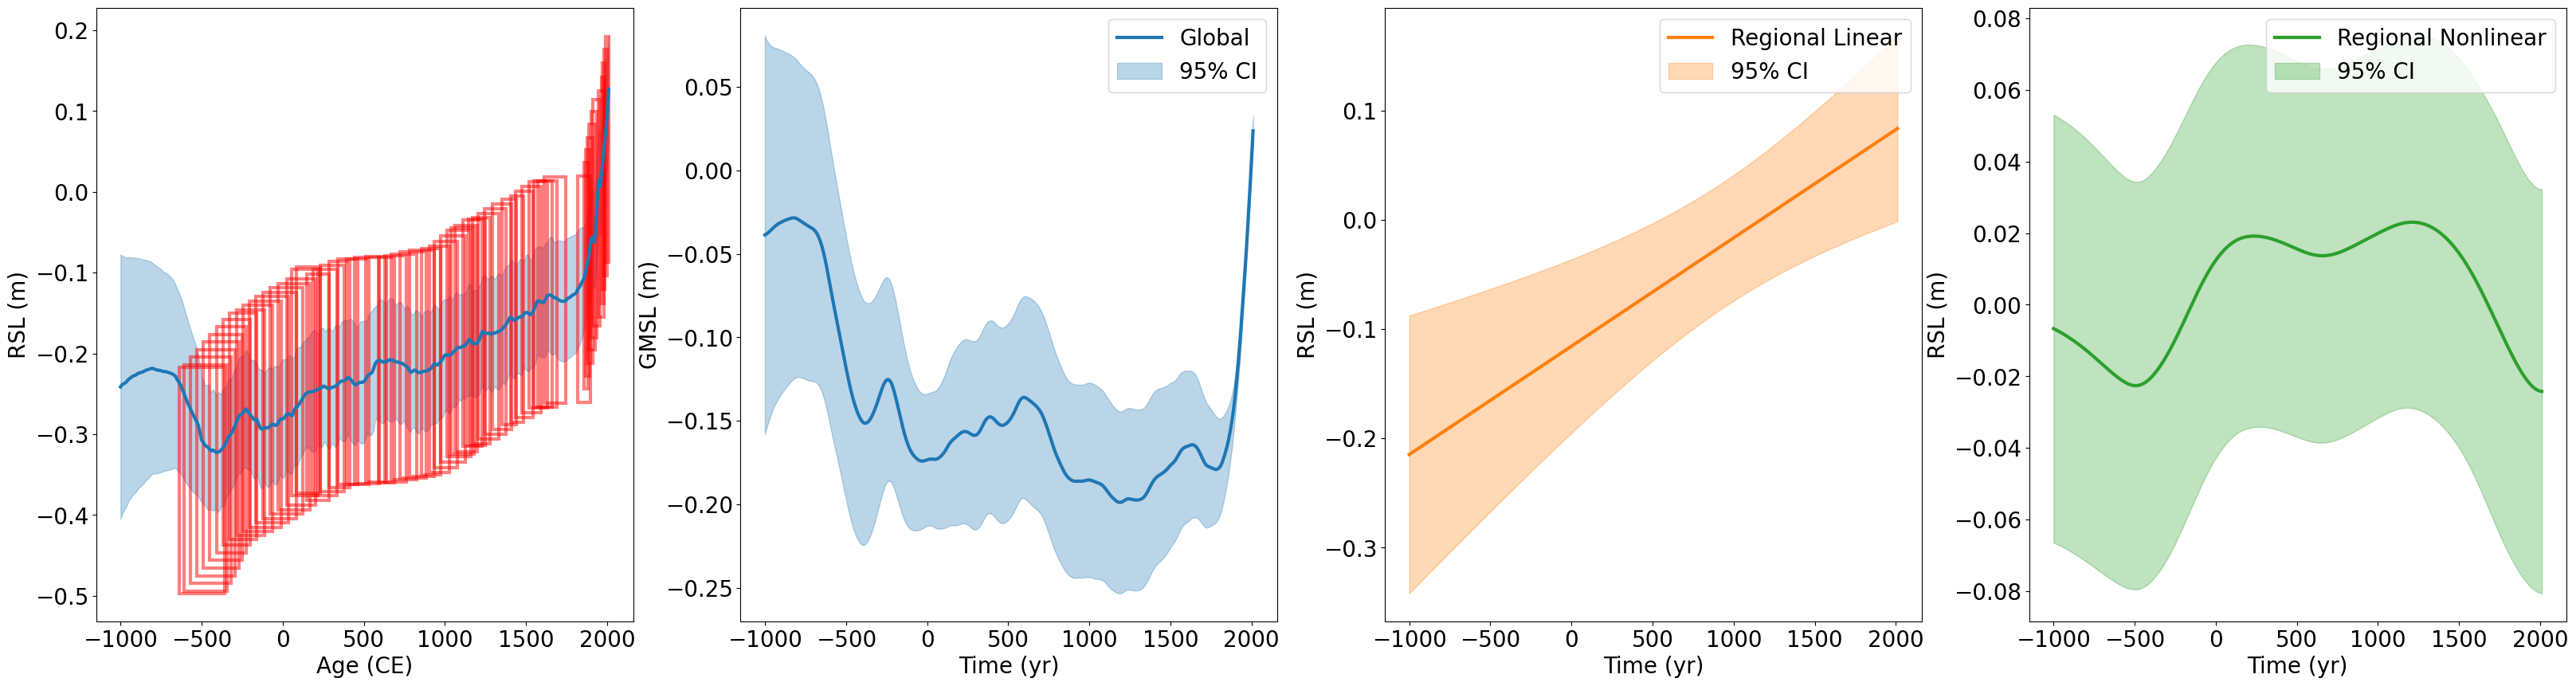

In [13]:
plt.figure(figsize=(40,10))
ax = plt.subplot(141)
data_index = np.sum(np.abs(X_all[:,1:]-data_point),axis=1)<1e-3
PSTHM.plot_uncertainty_boxes(X_all[:,0][data_index],y_no_GIA[data_index], X_sigma[data_index]*2,y_sigma[data_index]*2,ax=ax)
plt.plot(pred_matrix[:,0],y_mean.detach().numpy(),'C0',linewidth=3,label='Mean Prediction')
plt.fill_between(pred_matrix[:,0],y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.subplot(142)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()

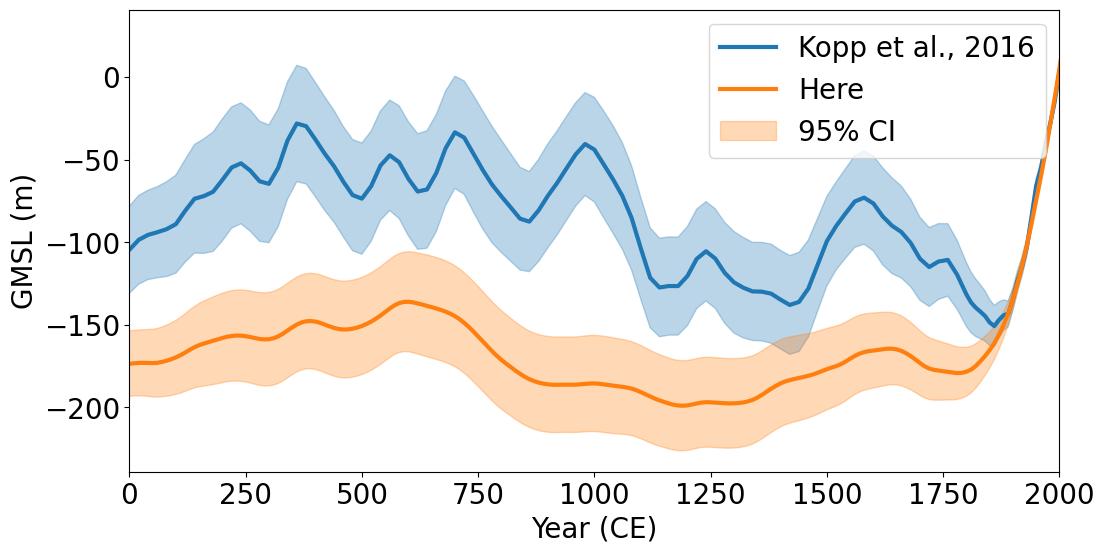

In [14]:

kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
kopp2016_cov = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=6,skiprows=2).iloc[:,1:]
plt.plot(kopp2016['Year'], kopp2016['mm'],label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016['Year'],kopp2016['mm']+1*kopp2016['1s'],kopp2016['mm']-1*kopp2016['1s'],alpha=0.3,color='C0')

plt.plot(test_age,global_mean.detach().numpy()*1000,'C1',linewidth=3,label='Here')
plt.fill_between(test_age,(global_mean.detach().numpy()-1*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+1*global_std.detach().numpy())*1000,color='C1',alpha=0.3,label='95% CI')
plt.xlim(0,2000)
plt.xlabel('Year (CE)')
plt.ylabel('GMSL (m)')
plt.legend()

#### Replicating results from Walker et al., 2022

The only difference is we do not use pusedo data to constrain the global sea-level between -100-100 and 1600-1800 CE. 

In [22]:
# filter out data with poor quality

pyro.clear_param_store()
#define global temporal kernel fast
global_kernel_f = PSTHM.Matern32(input_dim=1,geo=False)
global_kernel_f.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(30.)))
global_kernel_f.set_prior("variance", dist.Uniform(torch.tensor(1e-8), torch.tensor(1e-4)))

#define global temporal kernel slow
global_kernel_s = PSTHM.Matern32(input_dim=1,geo=False)
global_kernel_s.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(400.)))
global_kernel_s.set_prior("variance", dist.Uniform(torch.tensor(1e-4), torch.tensor(5e-1)))

#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = gp.kernels.Polynomial(input_dim=1)
regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-8), torch.tensor(1e-4)))
regional_linear_temporal_kernel.set_prior("bias", dist.Uniform(torch.tensor(2010.**2-0.5), torch.tensor(2010.**2+0.5)))
regional_linear_spatial_kernel = PSTHM.Matern21(input_dim=1,geo=True)
regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.20)))
regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

#define fast regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_f = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,geo=False)
regional_nl_temporal_kernel_f.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(1e-2)))
regional_nl_spatial_kernel_f = PSTHM.Matern21(input_dim=1,geo=True)
regional_nl_spatial_kernel_f.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.35)))
regional_nl_kernel_f = gp.kernels.Product(regional_nl_temporal_kernel_f, regional_nl_spatial_kernel_f)

#define slow regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_s = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,geo=False)
regional_nl_temporal_kernel_s.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(5e-2)))
regional_nl_spatial_kernel_s = PSTHM.Matern21(input_dim=1,s_lengthscale =regional_nl_spatial_kernel_f.s_lengthscale,geo=True)
regional_nl_kernel_s = gp.kernels.Product(regional_nl_temporal_kernel_s, regional_nl_spatial_kernel_s)

#define fast locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_f = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,
                                            variance =regional_nl_temporal_kernel_f.variance ,geo=False)
local_nl_spatial_kernel_f = PSTHM.Matern21(input_dim=1,geo=True)
local_nl_spatial_kernel_f.set_prior("s_lengthscale", dist.Uniform(torch.tensor(1e-4), torch.tensor(1e-3)))
local_nl_kernel_f = gp.kernels.Product(local_nl_temporal_kernel_f, local_nl_spatial_kernel_f)

#define slow locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_s = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,
                                            variance =regional_nl_temporal_kernel_s.variance ,geo=False)
local_nl_spatial_kernel_s = PSTHM.Matern21(input_dim=1,lengthscale = local_nl_spatial_kernel_f.s_lengthscale,geo=True)
local_nl_kernel_s = gp.kernels.Product(local_nl_temporal_kernel_s, local_nl_spatial_kernel_s)

#define white-noise kernel
sp_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=True,geo=False)
sp_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

s_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=False,geo=True)
s_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

#define constant offset kernel
constant_kernel = gp.kernels.Constant(input_dim=1)
constant_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-10),torch.tensor(1e-3)))

combined_sp_kernel = gp.kernels.Sum(global_kernel_f,global_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel_f)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel_f)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,s_whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,constant_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_linear_kernel)

N = len(X_all)
noise_cov = torch.zeros(N,N).double()
noise_cov.view(-1)[:: N + 1] += 1e-5 + torch.tensor(y_sigma**2)
noise_cov[np.outer((longitude>360) &(longitude<501) ,(longitude>360) &(longitude<501))] =  torch.tensor(HayGSL['Ycv']/1000**2).flatten()

gpr = PSTHM.GPRegression_V(torch.tensor(X_all), torch.tensor(y_no_GIA), combined_sp_kernel,noise=noise_cov,jitter=1e-5)


In [23]:
#Walker et al., 2022
gpr.kernel.kern1.kern0.variance = 1.21e-6
gpr.kernel.kern1.kern0.bias = 2010**2
gpr.kernel.kern1.kern1.s_lengthscale = 0.06283185307179587

gpr.kernel.kern0.kern1.variance = torch.tensor(1e-8)
gpr.kernel.kern0.kern0.kern1.variance =9e-10
gpr.kernel.kern0.kern0.kern0.kern1.variance = 9e-10

gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = 355
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.variance = 0.0009
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.0006981317007977319

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = 12
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = 0.0004
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.0006981317007977319

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = 355
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = 0.0009
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.20943951023931956

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = 12
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = 0.0004
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.20943951023931956

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.variance = 0.0169
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.lengthscale =355

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.variance = 4e-06
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.lengthscale = 12 


In [40]:
test_age = np.arange(-1000,2020,10)
#generate prediction for one location
data_point = X_all[300,1:]
pred_matrix = PSTHM.gen_pred_matrix(test_age,*data_point)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()
#-----------------define the kernel to decompose-----------------
test_global_kernel =   gp.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1)
test_global_kernel =   gp.kernels.Sum(test_global_kernel,gpr.kernel.kern0.kern1)

regional_linear_kernel = gpr.kernel.kern1
regional_nl_kernel =  gpr.kernel.kern0.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[test_global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()


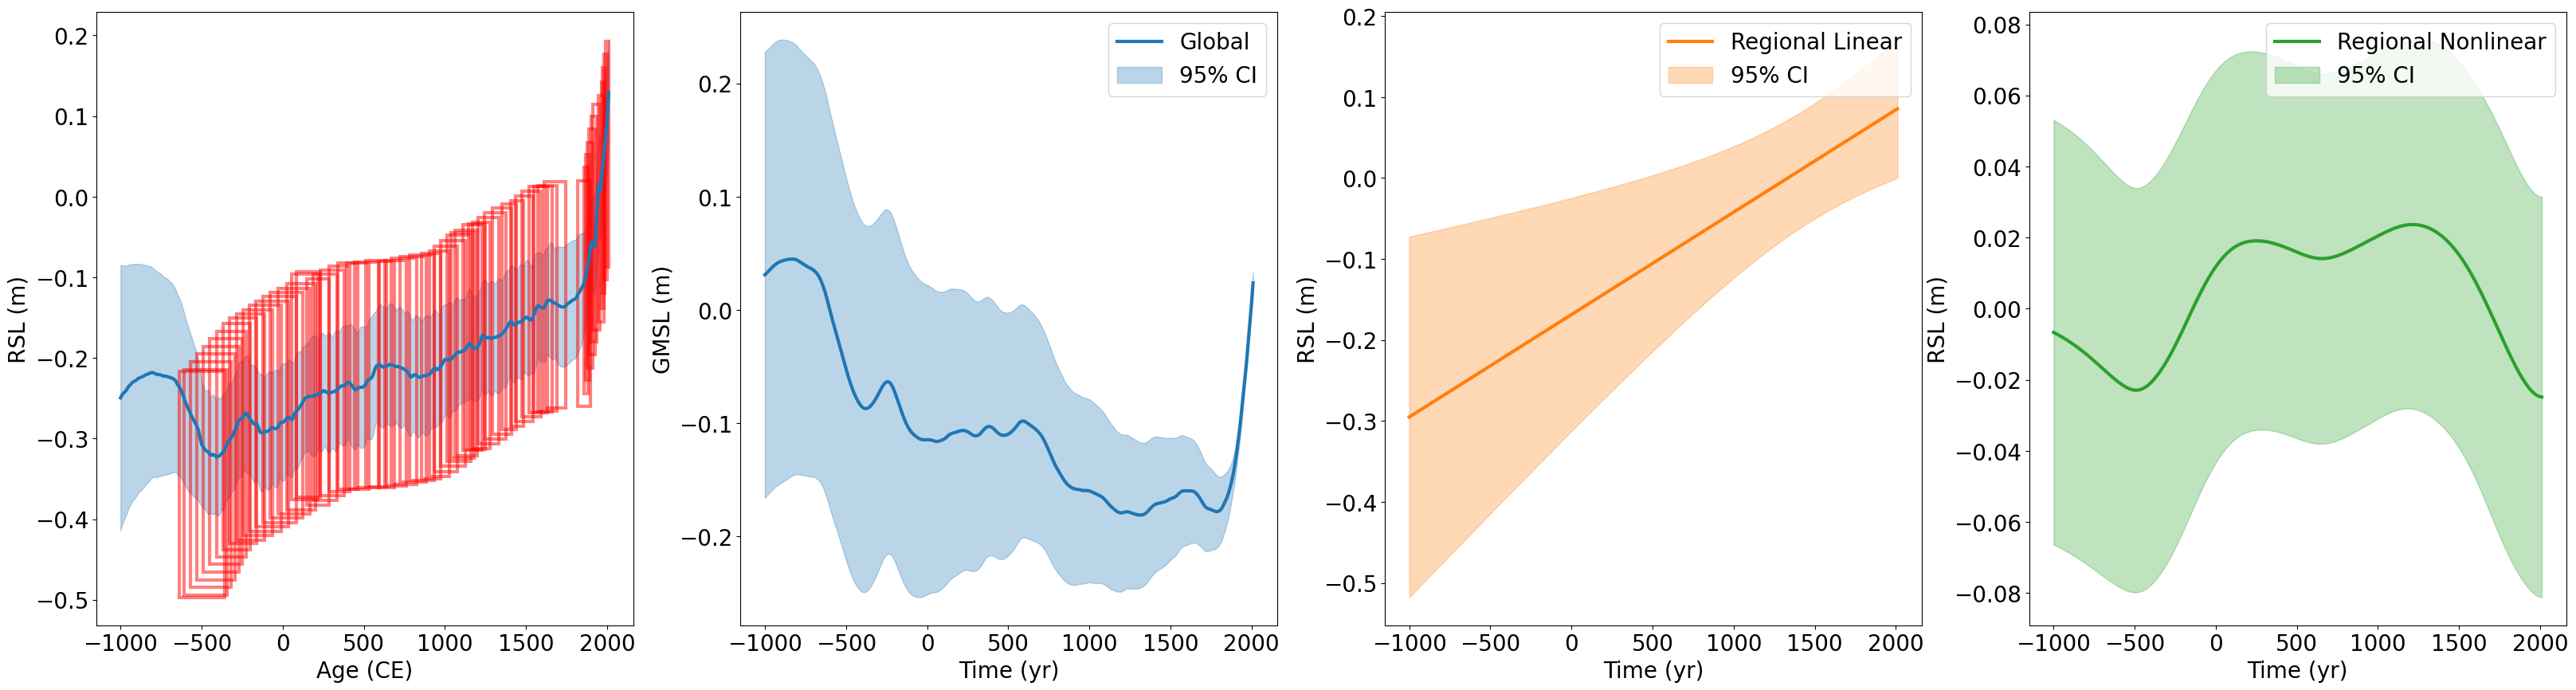

In [41]:
plt.figure(figsize=(40,10))
ax = plt.subplot(141)
data_index = np.sum(np.abs(X_all[:,1:]-data_point),axis=1)<1e-3
PSTHM.plot_uncertainty_boxes(X_all[:,0][data_index],y_no_GIA[data_index], X_sigma[data_index]*2,y_sigma[data_index]*2,ax=ax)
plt.plot(pred_matrix[:,0],y_mean.detach().numpy(),'C0',linewidth=3,label='Mean Prediction')
plt.fill_between(pred_matrix[:,0],y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.subplot(142)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()

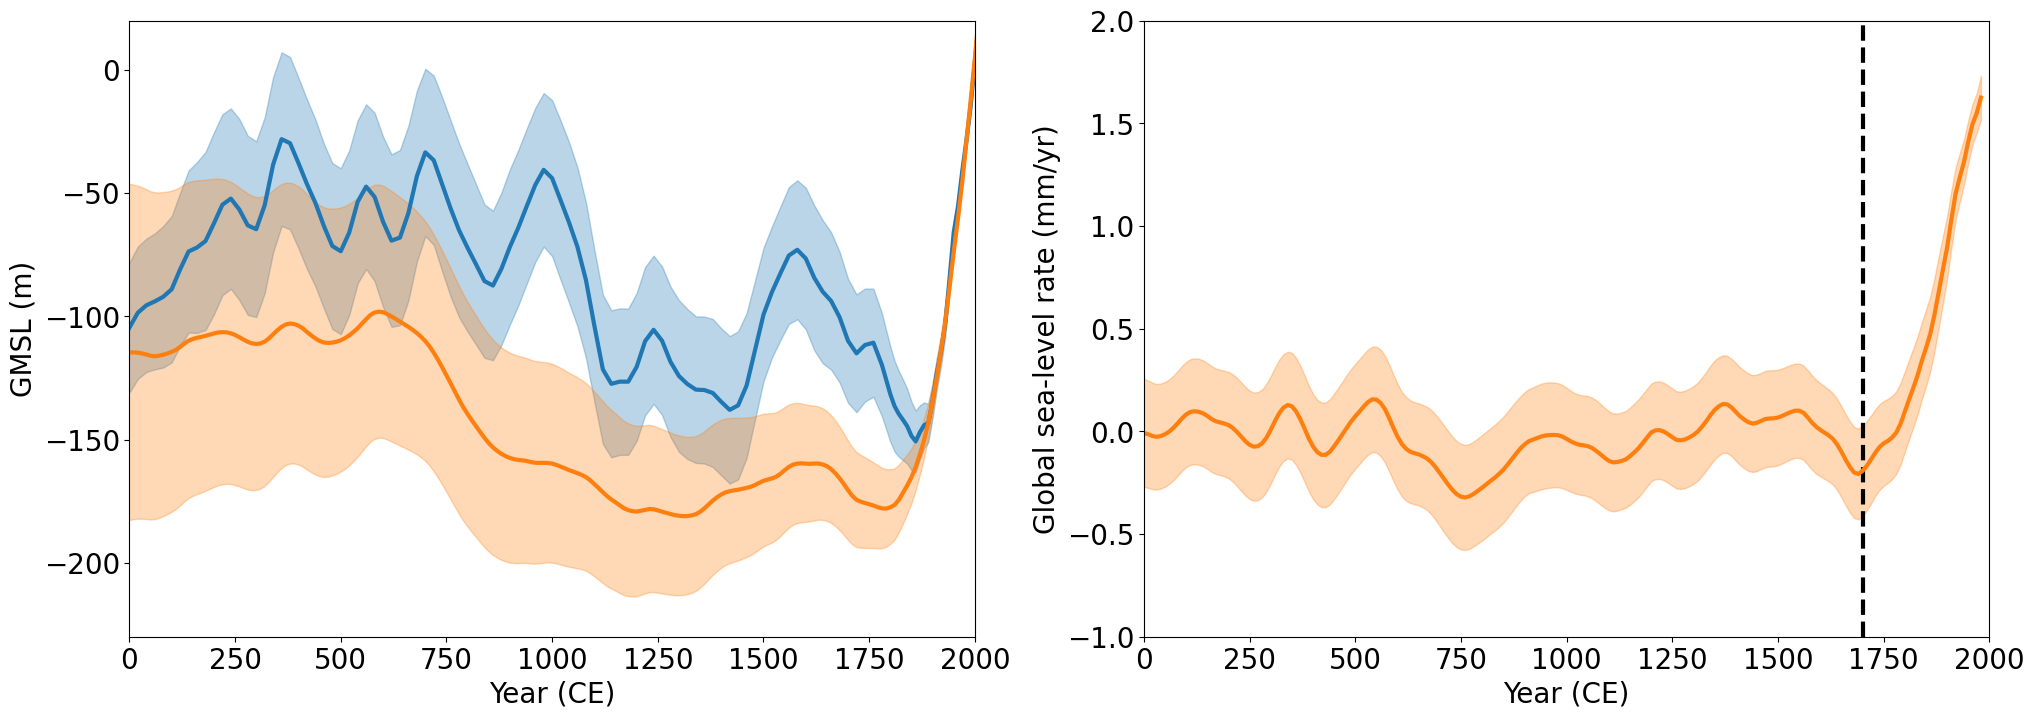

In [42]:

kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
kopp2016_cov = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=6,skiprows=2).iloc[:,1:]
plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(kopp2016['Year'], kopp2016['mm'],label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016['Year'],kopp2016['mm']+1*kopp2016['1s'],kopp2016['mm']-1*kopp2016['1s'],alpha=0.3,color='C0')
plt.plot(test_age,global_mean.detach().numpy()*1000,'C1',linewidth=3,label='Global')
plt.fill_between(test_age,(global_mean.detach().numpy()-1*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+1*global_std.detach().numpy())*1000,color='C1',alpha=0.3,label='95% CI')
plt.xlim(0,2000)
plt.ylim(-230,20)

plt.xlabel('Year (CE)')
plt.ylabel('GMSL (m)')

plt.subplot(122)
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(pred_matrix[:,0].detach().numpy(),global_var.detach().numpy(),global_mean.detach().numpy(),difftimestep=60)
kopp2016_rsl_time,kopp2016_rsl_rate,kopp2016_rsl_rate_sd = PSTHM.cal_rate_var(kopp2016['Year'].values,kopp2016_cov,kopp2016['mm'])
# plt.plot(kopp2016_rsl_time,kopp2016_rsl_rate,label='Kopp et al., 2016',lw=3)
# plt.fill_between(kopp2016_rsl_time,kopp2016_rsl_rate+2*kopp2016_rsl_rate_sd,kopp2016_rsl_rate-2*kopp2016_rsl_rate_sd,alpha=0.3,color='C0')

plt.plot(rsl_time,rsl_rate*1000,label='Here',lw=3,color='C1')
plt.fill_between(rsl_time,(rsl_rate-rsl_rate_sd)*1000,(rsl_rate+rsl_rate_sd)*1000,alpha=0.3,color='C1')
plt.vlines(1700,-1,2,color='k',linestyle='--',lw=3)
plt.ylim(-1,2)
plt.xlim(0,2000)
plt.xlabel('Year (CE)')
plt.ylabel('Global sea-level rate (mm/yr)');